<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

# Desafío 04

## Integrantes

- Acevedo Zain, Gaspar (acevedo.zain.gaspar@gmail.com)

## Consignas

- Extender el entrenamiento a más datos y tamaños de
secuencias mayores.
- Explorar el impacto de la cantidad de neuronas en
las capas recurrentes.
- Mostrar 5 ejemplos de traducciones generadas.

## Imports

In [1]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, Input, LSTM, SimpleRNN
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.utils import plot_model, to_categorical

import logging
import os
from pathlib import Path
from io import StringIO
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

## Constantes

In [2]:
SPANISH_TEXT_FILE = "./spa-eng/spa.txt"
MAX_NUM_SENTENCES = 6000
RANDOM_SEED = 40

## Carga de datos

De la misma manera que en la notebook utilizada como base, se utilizan los datos disponibles del **Tatoeba Project** de traducciones de texto en diferentes idiomas.

Se construirá un modelo traductor de inglés a español **seq2seq** utilizando **encoder-decoder**.

[LINK](https://www.manythings.org/anki/)

In [3]:
import os
if os.access('spa-eng', os.F_OK) is False:
    if os.access('spa-eng.zip', os.F_OK) is False:
        !curl -L -o 'spa-eng.zip' 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
    !unzip -q spa-eng.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
text_file = SPANISH_TEXT_FILE
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([RANDOM_SEED])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    # el tabulador señaliza la separación entre las oraciones
    # en ambos idiomas
    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 6000


In [5]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

## Funciones útiles

In [6]:
def input_output_tokenizer(input_sentences: list, output_sentences: list,
                           output_sentences_inputs: list,
                           max_vocab_size: int = 8000,
                           filters: str = '!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n'):
  """
  Función que crea los tokenizadores del idioma inglés (input) y del idioma
  español (output).
  Devuelve los tokenizadores, secuencias de enters y diccionarios de palabra
  a índice de cada idioma (inglés y español).
  Se utiliza como base el código provisto por la materia (sección "2 - Preprocesamiento")
  """
  # tokenizador de inglés
  input_tokenizer = Tokenizer(num_words=max_vocab_size)
  input_tokenizer.fit_on_texts(input_sentences)
  input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

  word2idx_inputs = input_tokenizer.word_index

  # tokenizador de español
  output_tokenizer = Tokenizer(num_words=max_vocab_size, filters=filters)
  output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
  output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
  output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

  word2idx_outputs = output_tokenizer.word_index

  # Se suma 1 para incluir el token de palabra desconocida
  num_words_output = min(len(word2idx_outputs) + 1, max_vocab_size)

  return input_tokenizer, input_integer_seq, word2idx_inputs, output_tokenizer, output_integer_seq, output_input_integer_seq, word2idx_outputs, num_words_output

In [7]:
def generar_encoder_decoder_sequences(input_integer_seq: list,
                                      output_integer_seq: list,
                                      output_input_integer_seq: list,
                                      num_words_output: int,
                                      padding: str = 'post',
                                      max_input_len: int = 16,
                                      max_out_len: int = 18):
  """
  Genera las secuencias de input del encoder y decoder, como así también el
  output del decoder, utilizando Padding.
  Se utiliza como base el código provisto por la materia (sección "2 - Preprocesamiento")
  """
  encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)

  decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding=padding)

  decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding=padding)
  decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)

  return encoder_input_sequences, decoder_input_sequences, decoder_output_sequences, decoder_targets

In [8]:
def crear_matriz_embeddings_para_inputs(model_embeddings, word2idx_inputs, max_vocab_size: int):
  """
  Crea la matriz de embeddings para los inputs (inglés).
  Se utiliza como base el código provisto por la materia (sección "3 - Preparar los embeddings").
  """
  embed_dim = model_embeddings.N_FEATURES
  words_not_found = []

  nb_words = min(max_vocab_size, len(word2idx_inputs))
  embedding_matrix = np.zeros((nb_words, embed_dim))

  for word, i in word2idx_inputs.items():
      if i >= nb_words:
          continue
      embedding_vector = model_embeddings.get_words_embeddings(word)[0]
      if (embedding_vector is not None) and len(embedding_vector) > 0:

          embedding_matrix[i] = embedding_vector
      else:
          words_not_found.append(word)
  return embedding_matrix, words_not_found, nb_words, embed_dim

In [9]:
def generar_modelos(n_units: int, max_input_len: int, max_out_len: int,
                    num_words_output: int, embedding_matrix, nb_words, embed_dim,
                    activation: str ='softmax',
                    loss:str ='categorical_crossentropy',
                    optimizer:str = "Adam", metrics:list = ['accuracy']):
  """
  Genera los modelos encoder-decoder, encoder (por separado), y decoder (por separado).
  Se utiliza como base el código provisto por la materia (sección "4 - Entrenar el modelo").
  """
  # define training encoder
  encoder_inputs = Input(shape=(max_input_len,))

  encoder_embedding_layer = Embedding(
            input_dim=nb_words,
            output_dim=embed_dim,
            input_length=max_input_len,
            weights=[embedding_matrix],
            trainable=False)

  encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

  encoder = LSTM(n_units, return_state=True)
  encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
  encoder_states = [state_h, state_c]

  # define training decoder
  decoder_inputs = Input(shape=(max_out_len, ))
  decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
  decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

  decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

  # Dense
  decoder_dense = Dense(num_words_output, activation=activation)
  decoder_outputs = decoder_dense(decoder_outputs)
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  # model.summary()

  # Modelo solo encoder

  # define inference encoder
  encoder_model = Model(encoder_inputs, encoder_states)

  # Modelo solo decoder (para realizar inferencia)

  # define inference decoder
  decoder_state_input_h = Input(shape=(n_units,))
  decoder_state_input_c = Input(shape=(n_units,))
  decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

  # En cada predicción habrá una sola palabra de entrada al decoder,
  # que es la realimentación de la palabra anterior
  # por lo que hay que modificar el input shape de la layer de Embedding
  decoder_inputs_single = Input(shape=(1,))
  decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

  decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
  decoder_states = [state_h, state_c]
  decoder_outputs = decoder_dense(decoder_outputs)
  decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

  return model, encoder_model, decoder_model

## Definición de Embeddings

In [10]:
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [11]:
# !curl -L -o 'gloveembedding.pkl' 'https://drive.google.com/u/0/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t'

In [12]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

## TBD

### 2 - Preprocesamiento

In [13]:
MAX_VOCAB_SIZE = 3000

In [14]:
input_tokenizer, input_integer_seq, word2idx_inputs, output_tokenizer, output_integer_seq, output_input_integer_seq, word2idx_outputs, num_words_output = input_output_tokenizer(input_sentences=input_sentences, output_sentences=output_sentences, output_sentences_inputs=output_sentences_inputs, max_vocab_size=MAX_VOCAB_SIZE)

In [15]:
max_input_len = max(len(sen) for sen in input_integer_seq)
max_out_len = max(len(sen) for sen in output_integer_seq)

print("Palabras en el vocabulario:", len(word2idx_inputs))
print("Sentencia de entrada más larga:", max_input_len)
print("Palabras en el vocabulario:", len(word2idx_outputs))
print("Sentencia de salida más larga:", max_out_len)
print("Cantidad de rows del dataset:", len(input_integer_seq))
print("Cantidad de palabras de salida:", num_words_output)

Palabras en el vocabulario: 3851
Sentencia de entrada más larga: 32
Palabras en el vocabulario: 5721
Sentencia de salida más larga: 36
Cantidad de rows del dataset: 6000
Cantidad de palabras de salida: 3000


In [16]:
MAX_INPUT_LEN = max_input_len
MAX_OUTPUT_LEN = max_out_len

In [17]:
encoder_input_sequences, decoder_input_sequences, decoder_output_sequences, decoder_targets = generar_encoder_decoder_sequences(input_integer_seq=input_integer_seq, output_integer_seq=output_integer_seq, output_input_integer_seq=output_input_integer_seq, num_words_output=num_words_output, max_input_len=MAX_INPUT_LEN, max_out_len=MAX_OUTPUT_LEN)

In [18]:
print("encoder_input_sequences shape:", encoder_input_sequences.shape)
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

encoder_input_sequences shape: (6000, 32)
decoder_input_sequences shape: (6000, 36)


### 3 - Preparar los embeddings

In [19]:
# Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [20]:
embedding_matrix, words_not_found, nb_words, embed_dim = crear_matriz_embeddings_para_inputs(model_embeddings=model_embeddings, word2idx_inputs=word2idx_inputs, max_vocab_size=MAX_VOCAB_SIZE)

In [21]:
print('Cantidad de embeddings con palabras nulas (null word embeddings):', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))
print('Dimensión de los embeddings de la secuencia en inglés:', embedding_matrix.shape)

Cantidad de embeddings con palabras nulas (null word embeddings): 17
Dimensión de los embeddings de la secuencia en inglés: (3000, 50)


### 4 - Entrenar el modelo

In [22]:
N_UNITS = 128
EPOCHS = 15
VALIDATION_SPLIT = 0.2

In [23]:
model, encoder_model, decoder_model = generar_modelos(n_units=N_UNITS, max_input_len=MAX_INPUT_LEN, max_out_len=MAX_OUTPUT_LEN, num_words_output=num_words_output, embedding_matrix=embedding_matrix, nb_words=nb_words, embed_dim=embed_dim)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [29]:
# plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
# plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT)

Epoch 1/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.7815 - loss: 3.4104 - val_accuracy: 0.8453 - val_loss: 1.0330
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8441 - loss: 1.0419 - val_accuracy: 0.8510 - val_loss: 0.9906
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8480 - loss: 0.9988 - val_accuracy: 0.8522 - val_loss: 0.9725
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8481 - loss: 0.9886 - val_accuracy: 0.8520 - val_loss: 0.9588
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8488 - loss: 0.9652 - val_accuracy: 0.8547 - val_loss: 0.9444
Epoch 6/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8497 - loss: 0.9486 - val_accuracy: 0.8552 - val_loss: 0.9307
Epoch 7/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8531 - loss: 0.9163 - val_accuracy: 0.8563 - val_loss: 0.9143
Epoch 8/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8539 - loss: 0.9005 - val_acc

### 5 - Gráficos

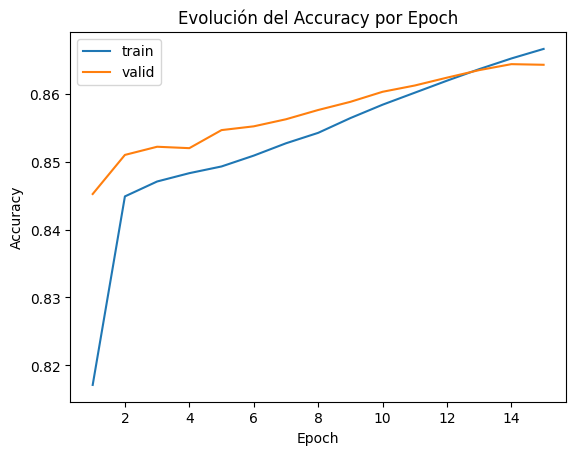

In [31]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evolución del Accuracy por Epoch")
plt.show()

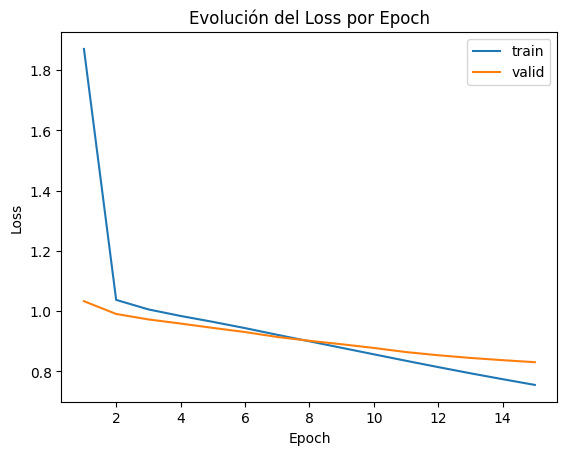

In [36]:
epoch_count = range(1, len(hist.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolución del Loss por Epoch")
plt.show()

### 5 - Inferencia

In [ ]:
'''
Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)
'''

In [ ]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [ ]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

In [ ]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)